# Decoupling fusion & differentiation

## Installations & Downloads

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
import scipy
import pandas as pd


sys.path.append('/sise/home/shakarch/muscle-formation-diff')
sys.path.append(os.path.abspath('..'))

from TimeSeriesAnalysis.utils.data_load_save import *
from TimeSeriesAnalysis.utils.plots_functions_utils import *

import TimeSeriesAnalysis.consts as consts
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *
from TimeSeriesAnalysis.single_cell_properties_calc import get_displacement

import warnings
warnings.simplefilter('ignore', pd.errors.DtypeWarning)
sys.path.append(r'C:\Users\Amit\PycharmProjects\muscle-formation-diff')
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

# Load the data

In [2]:
import pandas as pd

# load the raw data with fusion tags
df = pd.read_csv(r"muscle-formation-diff/data/mastodon/no_reg_S3 all detections.csv", encoding="cp1252", header=[0, 1]) # header=[0, 1]
df.columns = ['_'.join(col) for col in df.columns]
# df = df[df["manual_manual"] == 1]
# df.rename(columns={"manual_manual": "manual"}, inplace=True)
df.rename(columns=lambda x: x.replace("_", " ").strip(), inplace=True)
fusion_cols = ['Spot track ID', 'Spot frame', 'Spot position X', 'Spot position Y', 'manual manual'] + [col for col in df.columns if "First" in col]
df = df[fusion_cols]
df.rename(columns=lambda x: x.split(" ")[3] if "First" in x else x, inplace=True)

df = df[1:]
df.head()

,Spot track ID,Spot frame,Spot position X,Spot position Y,manual manual,140,141,142,143,144,...,251,252,253,254,255,256,257,258,259,260
1,0.0,0.0,82.5437911070555,10.49789435455889,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29851.0,0.0,213.79559531205967,32.73254368213615,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,122.63815144419624,28.349933514620485,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29849.0,0.0,36.966336149983825,29.21578029035298,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.0,0.0,137.5499432675,11.600337583952934,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[['Spot track ID', 'Spot track ID', 'Spot position X', 'Spot position Y']]

In [3]:
df = df.astype(float)

c = df.iloc[:,5:].idxmax(axis=1)
is_valid = df.iloc[:,5:].sum(axis=1) > 0
c[~is_valid] = np.nan
df["fusion_frame"] = c
df = df.dropna(subset=["fusion_frame"])
df = df.drop_duplicates(subset=['fusion_frame', 'Spot track ID'])
fusion_time_df = df[['Spot track ID' ,'fusion_frame','manual manual']]
fusion_time_df

,Spot track ID,fusion_frame,manual manual
444,217.0,179,1.0
34667,9410.0,225,1.0
34847,19015.0,179,1.0
42673,16792.0,173,1.0
45431,12539.0,195,1.0
...,...,...,...
897141,14334.0,239,1.0
898835,7338.0,170,1.0
898988,21229.0,166,1.0
899571,7126.0,187,1.0


In [17]:
pd.set_option('max_rows', 80)
fusion_time_df.drop_duplicates(subset=['Spot track ID']).sort_values("Spot track ID")[["Spot track ID", "fusion_frame"]].to_csv("tmp.csv")

In [10]:
lst = list(fusion_time_df["Spot track ID"].unique())
lst.sort()
lst

[217.0,
 464.0,
 1393.0,
 1394.0,
 2766.0,
 3129.0,
 3642.0,
 3661.0,
 4485.0,
 4663.0,
 4964.0,
 5017.0,
 5594.0,
 5727.0,
 6204.0,
 6319.0,
 6398.0,
 6402.0,
 6447.0,
 6992.0,
 7126.0,
 7338.0,
 7465.0,
 7642.0,
 7791.0,
 7874.0,
 8077.0,
 8601.0,
 8665.0,
 9245.0,
 9410.0,
 9431.0,
 9433.0,
 10114.0,
 10275.0,
 10490.0,
 10887.0,
 11115.0,
 11188.0,
 11485.0,
 12208.0,
 12539.0,
 12613.0,
 13402.0,
 13974.0,
 14147.0,
 14334.0,
 14847.0,
 14936.0,
 16025.0,
 16064.0,
 16103.0,
 16111.0,
 16368.0,
 16792.0,
 17012.0,
 17043.0,
 17223.0,
 19015.0,
 19256.0,
 19351.0,
 19443.0,
 19904.0,
 20883.0,
 21229.0,
 21552.0,
 21959.0,
 22442.0,
 23913.0,
 23928.0,
 25539.0,
 27245.0,
 27908.0,
 28872.0,
 28958.0,
 29092.0]

In [5]:
# load single cell properties data
properties_df_s3 =  get_all_properties_df("actin_intensity", 1, 5, scores_vid_num=3, reg_method=params.registration_method)
properties_df_s3 = properties_df_s3.drop_duplicates(subset=["Spot frame", "Spot track ID"])

FileNotFoundError: [Errno 2] No such file or directory: '/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/30-07-2022-actin_intensity local dens-False, s1, s5 train win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_/S3_properties_MeanOpticalFlowReg_.pkl'

In [ ]:
# merge single cell properties data with fusion time
fusions_properties = fusion_time_df.merge(properties_df_s3, on=["Spot track ID"], how="left")
fusions_properties["time"] = fusions_properties["Spot frame"] * 5 / 60
fusions_properties["fusion_time"] = fusions_properties["fusion_frame"].astype(float) * 5 / 60
fusions_properties["fusion_frame"] = fusions_properties["fusion_frame"].astype(float)

fusions_properties.head()

In [21]:
# save to csv for Hila
fusions_properties[["Spot track ID", "Spot frame","fusion_time", "Spot position X", "Spot position Y"]].to_csv("annotated_fusions.csv")

In [22]:
no_data_tracks = []
untracked_cells_ids = []
for track_id in fusions_properties["Spot track ID"].unique():
    track_data = fusions_properties[(fusions_properties["Spot track ID"]==track_id)]
    if len(track_data)<=1:
        if track_data["manual manual"].sum()==0:
            untracked_cells_ids.append(track_id)
        else:
            no_data_tracks.append(track_id)
        
print("number of fusion annotated cells: ", fusions_properties["Spot track ID"].nunique())
print(f"number of untracked cells: {len(untracked_cells_ids)}/{fusions_properties['Spot track ID'].nunique()}")
print(f"number of no data cells: {len(no_data_tracks)}/{fusions_properties['Spot track ID'].nunique()}")
print(f"no data cells: {no_data_tracks}")

number of fusion annotated cells:  76
number of untracked cells: 16/76
number of no data cells: 14/76
no data cells: [6204.0, 8077.0, 16103.0, 4663.0, 20883.0, 10114.0, 25539.0, 6402.0, 23913.0, 13974.0, 21959.0, 19443.0, 5594.0, 6398.0]


In [23]:
properties_df_s3[properties_df_s3["Spot track ID"]==6204.0]

,score_motility,score_intensity,coordination,Spot frame,time,Spot track ID,speed,speed_change,Spot position X,Spot position Y,min,max,mean,sum,x,y,directionality_ratio,directionality_cos_alpha


# Inspect each annotated cell

In [6]:
diff_score_1st_fusion = fusions_properties[(fusions_properties["time"]==fusions_properties["fusion_time"])]
print(f"average differentiation score on first fusion (motility): {round(diff_score_1st_fusion['score_motility'].mean(),3)} +- {round(diff_score_1st_fusion['score_motility'].std(),3)}")
print(f"average differentiation score on first fusion (intensity): {round(diff_score_1st_fusion['score_intensity'].mean(),3)} +- {round(diff_score_1st_fusion['score_intensity'].std(),3)}")

average differentiation score on first fusion (motility): 0.595 +- 0.267
average differentiation score on first fusion (intensity): 0.642 +- 0.219


## single cell examination

217.0


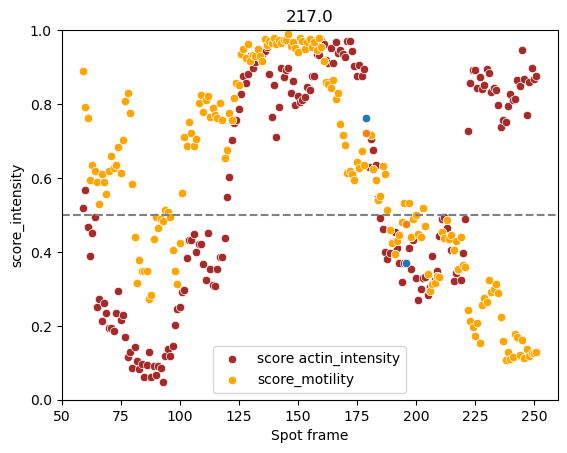

9410.0


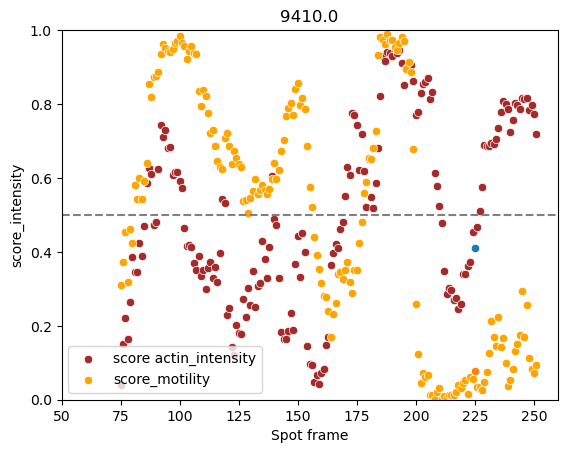

19015.0


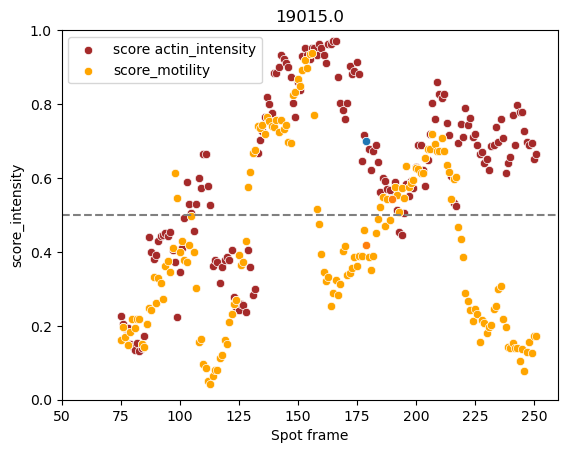

16792.0


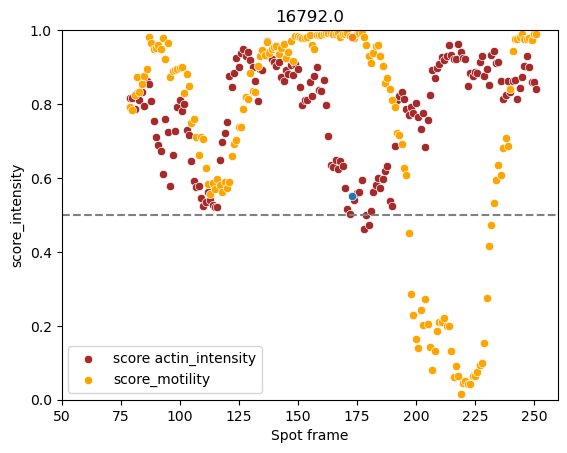

12539.0


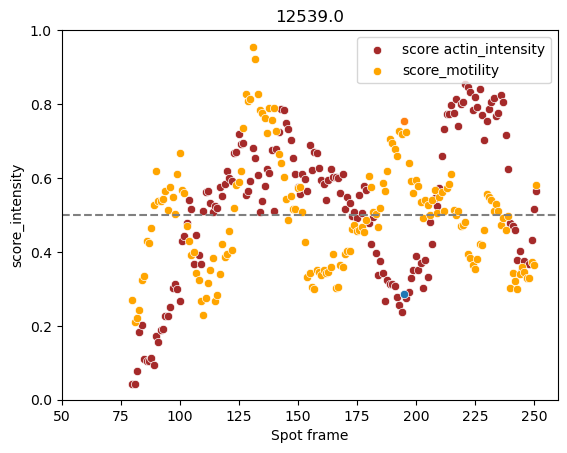

14147.0
11188.0


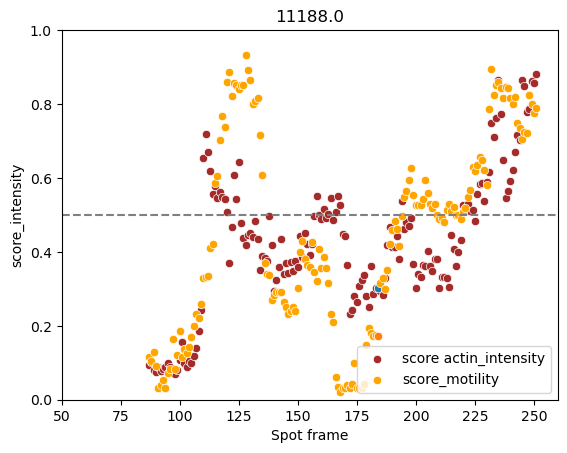

9245.0


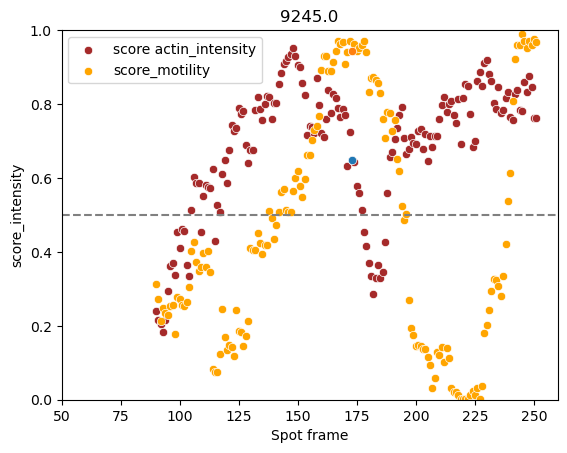

1394.0


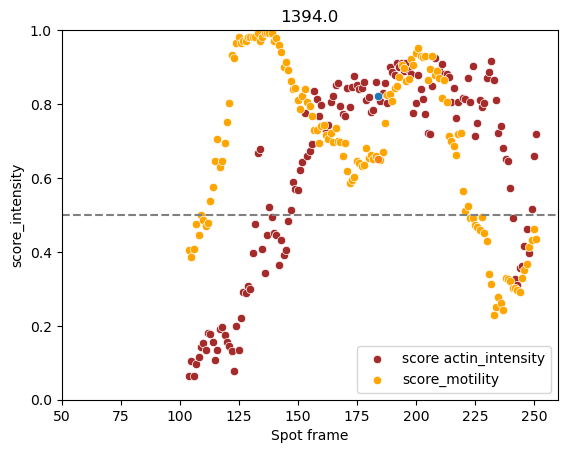

27245.0


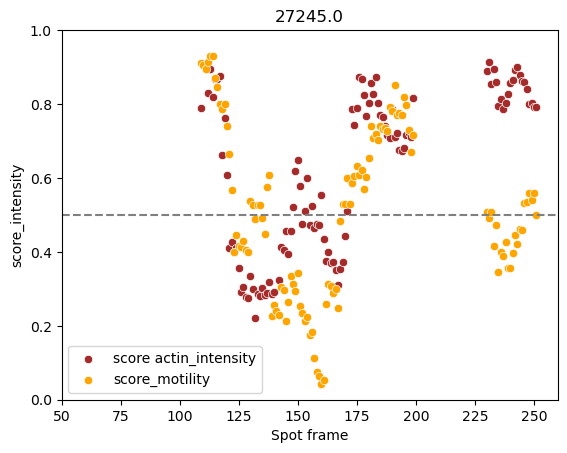

17012.0


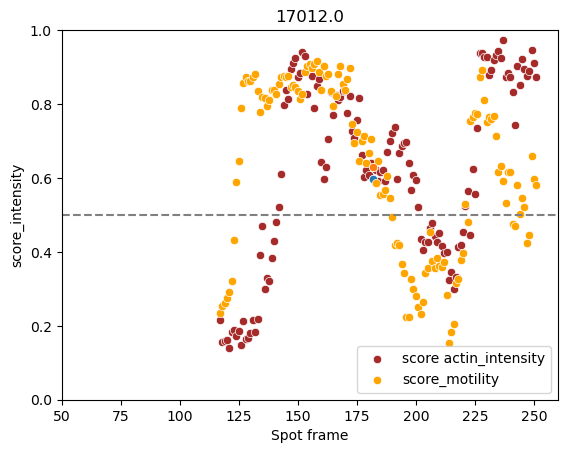

16025.0


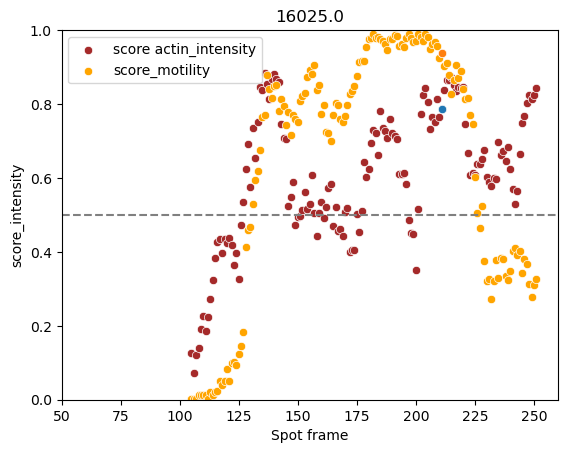

14936.0


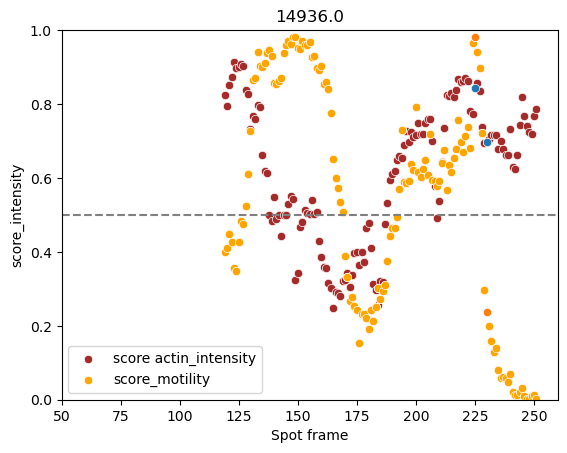

3661.0


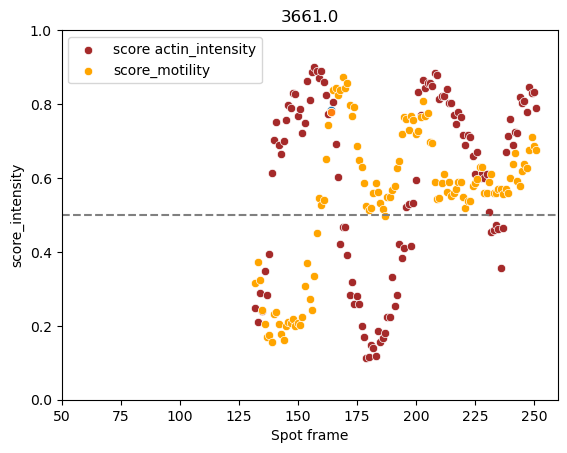

16064.0


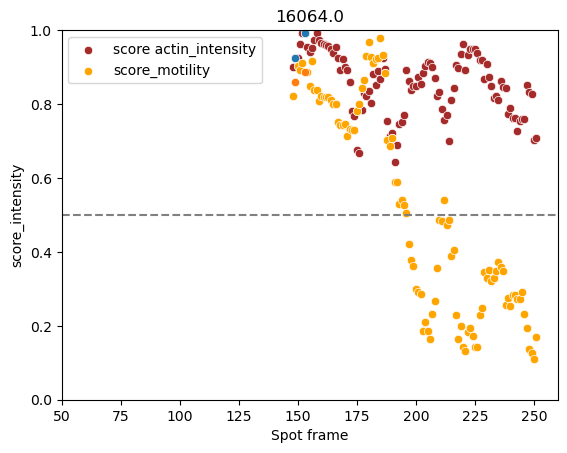

6204.0
14847.0


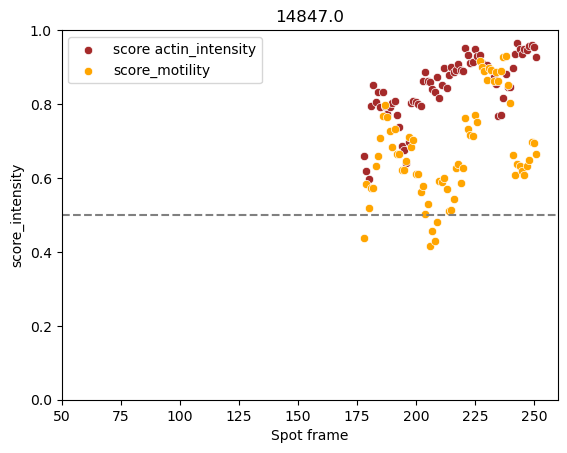

6319.0
19256.0


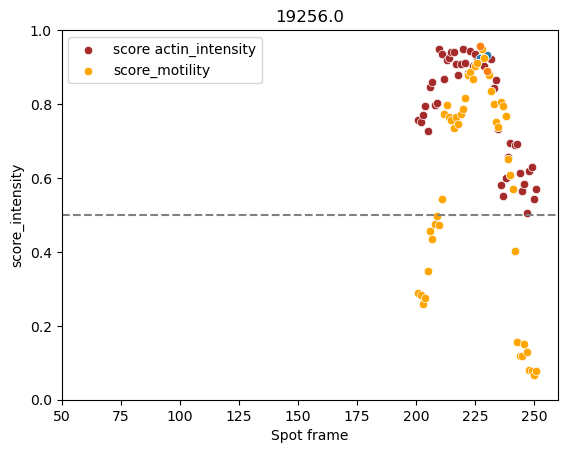

7874.0
8077.0
29092.0
16368.0


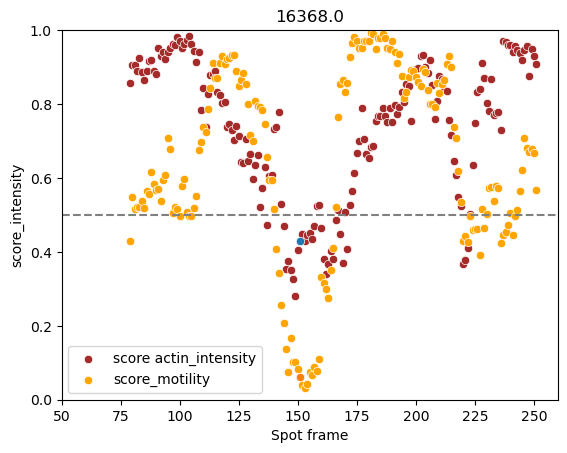

11485.0
10887.0


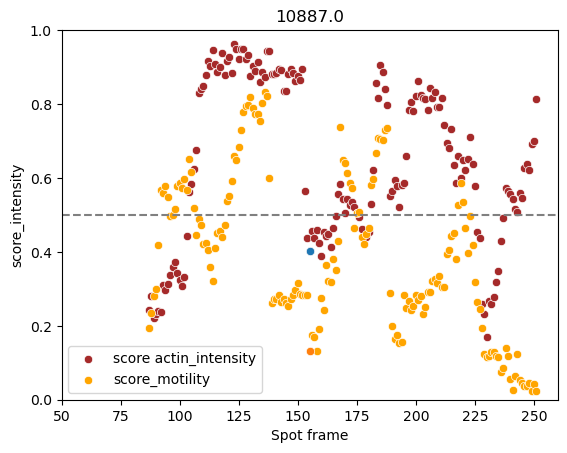

16103.0
16111.0


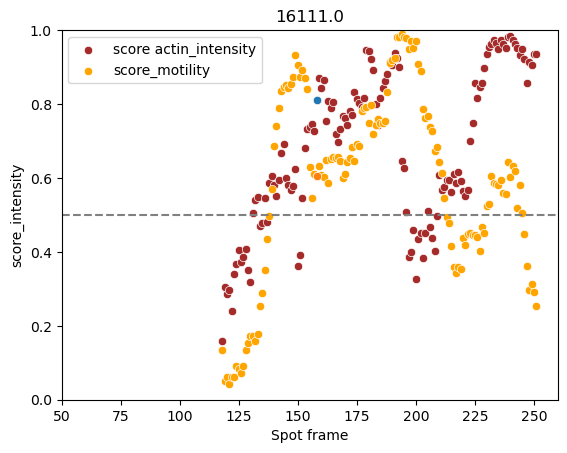

5727.0
17043.0


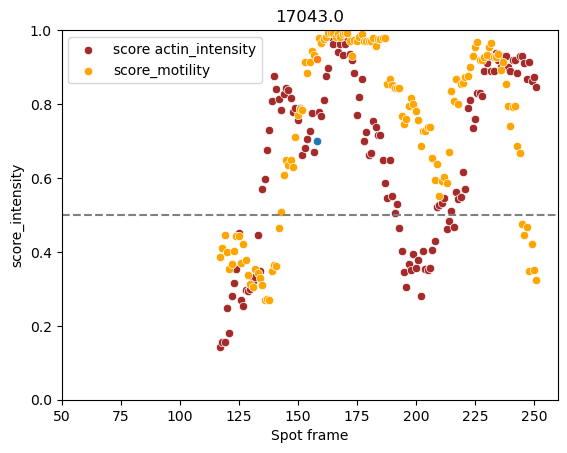

2766.0


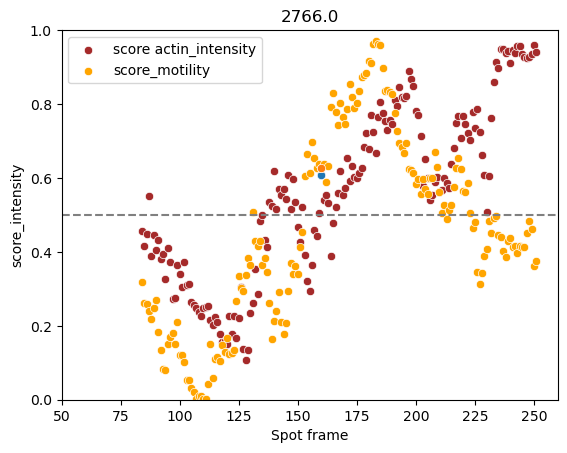

1393.0
12613.0


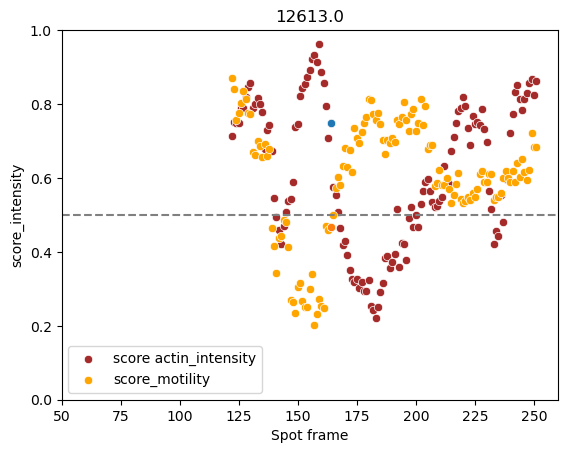

4663.0
6992.0


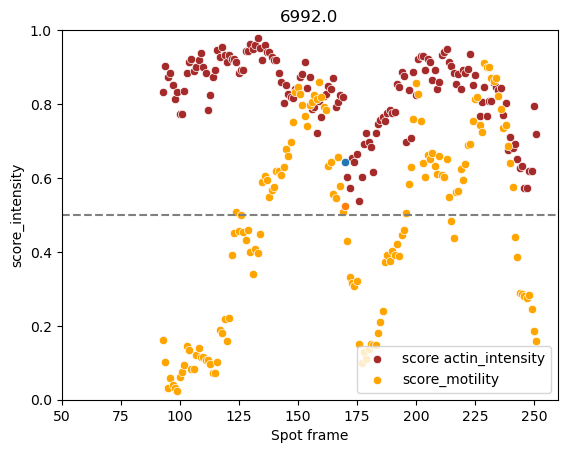

11115.0


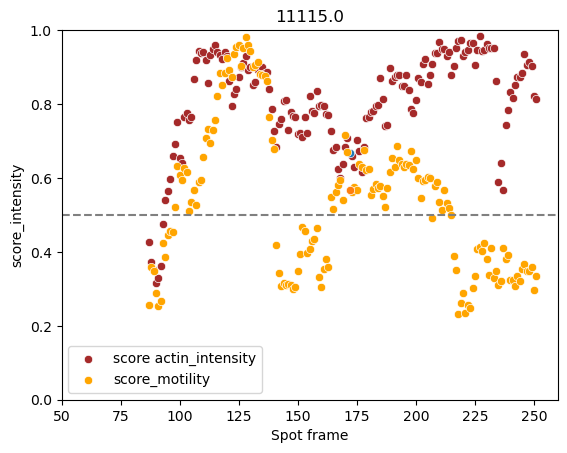

7791.0


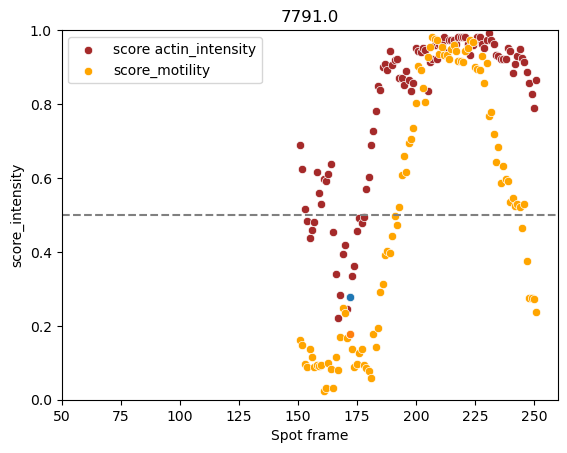

3642.0


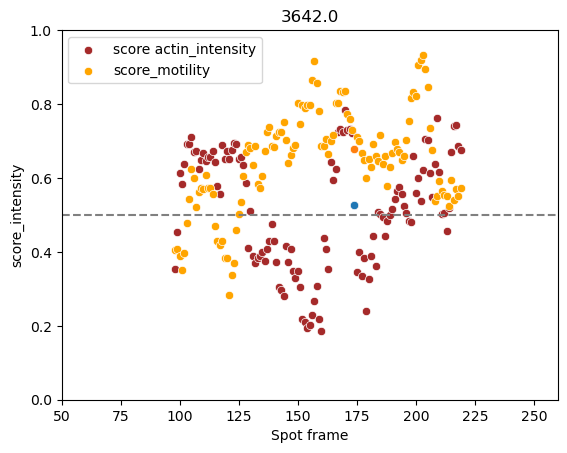

3129.0
27908.0


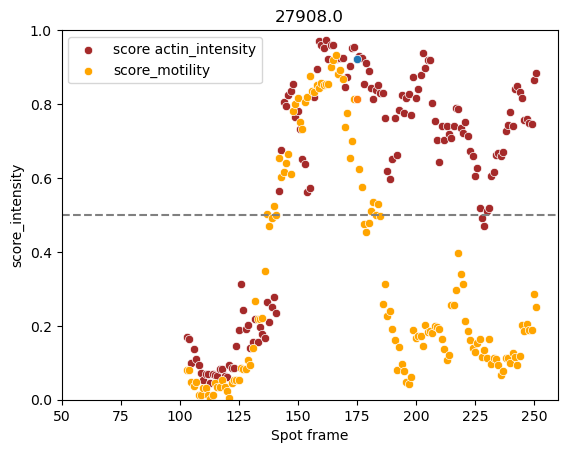

12208.0


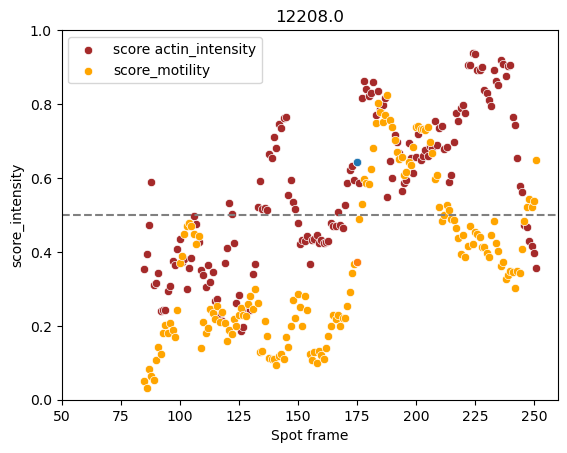

28872.0


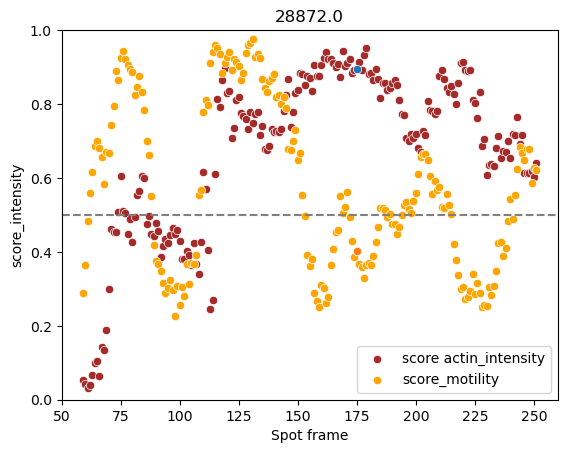

7642.0
20883.0
4964.0


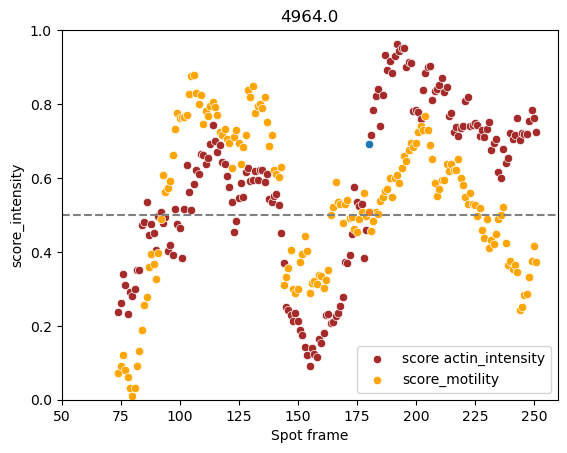

8665.0


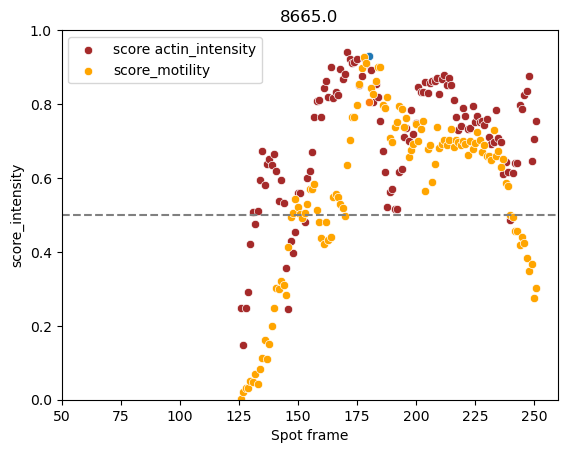

10490.0


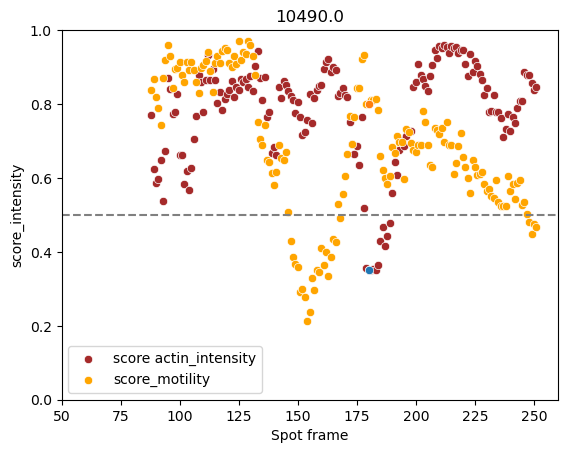

13402.0


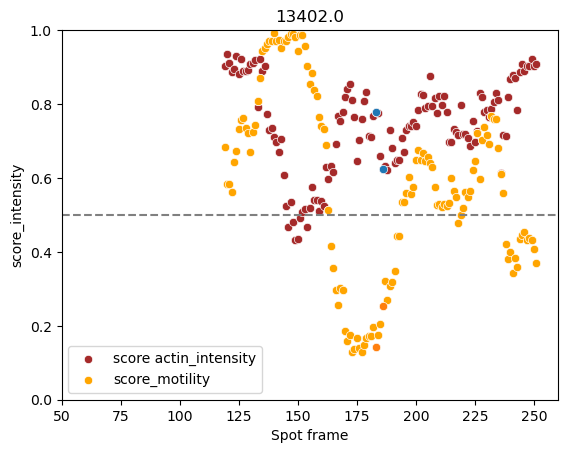

28958.0


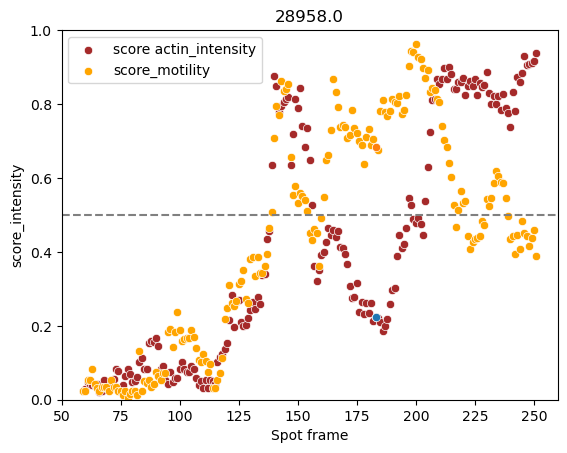

9431.0
10114.0
25539.0
6402.0
22442.0
464.0
4485.0
9433.0
19351.0


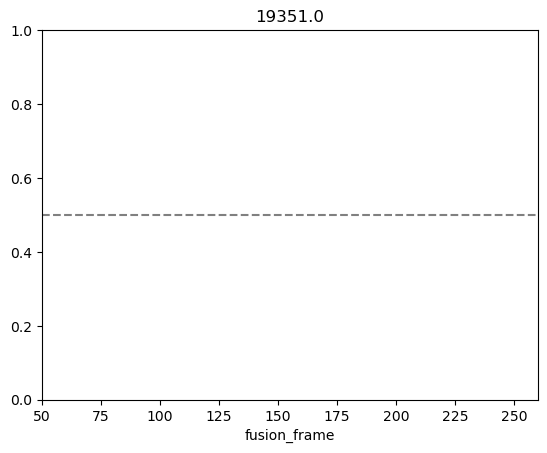

21552.0


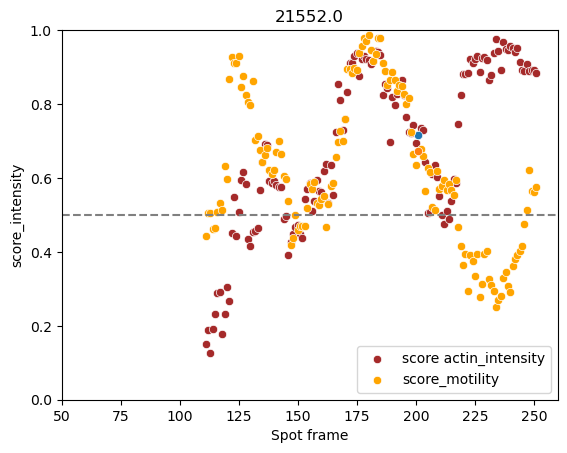

7465.0


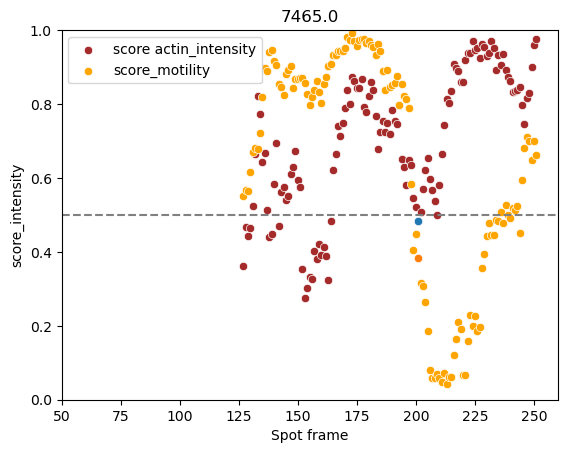

17223.0


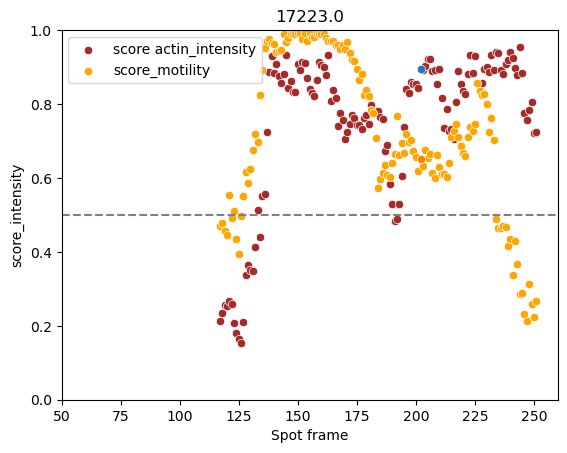

8601.0


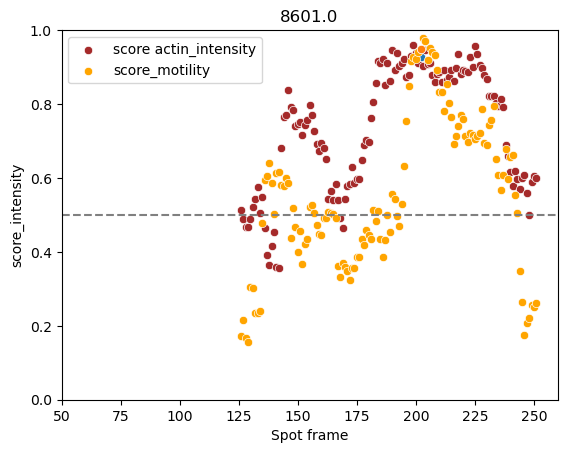

10275.0
23928.0


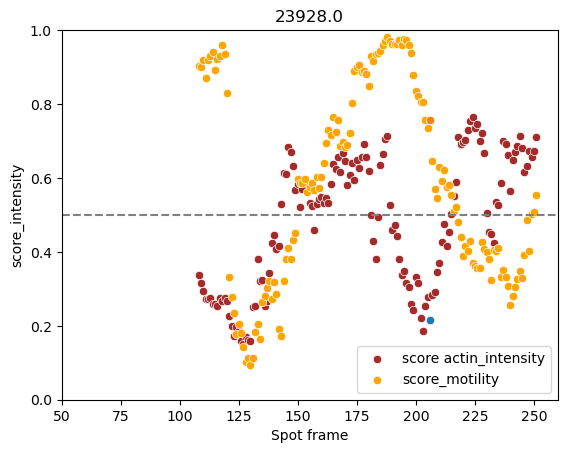

5017.0
23913.0
13974.0
6447.0


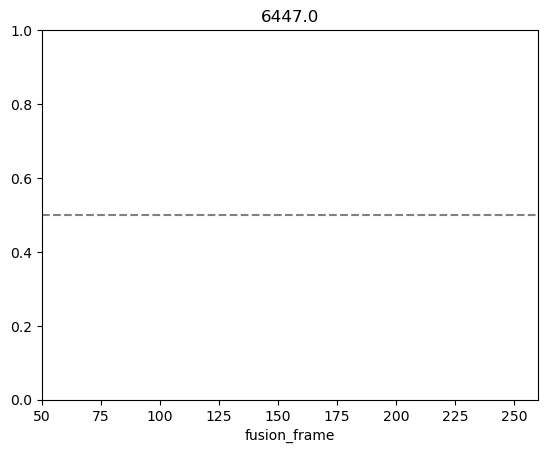

21959.0
19443.0
5594.0
19904.0


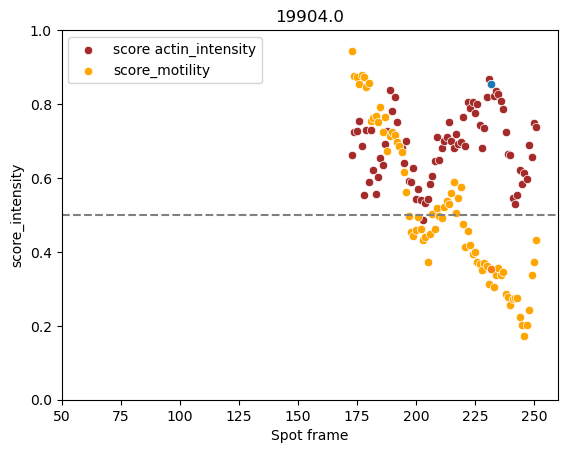

14334.0


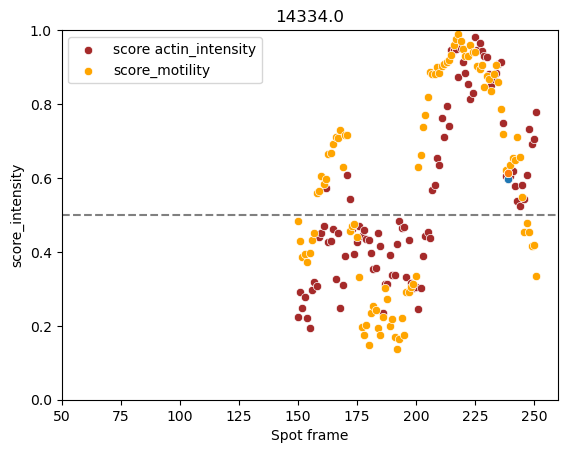

7338.0


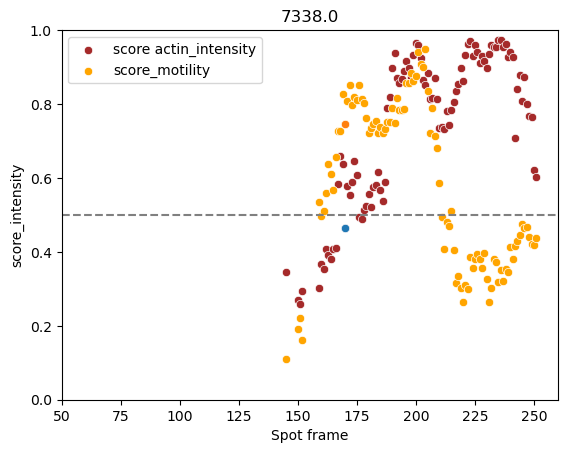

21229.0


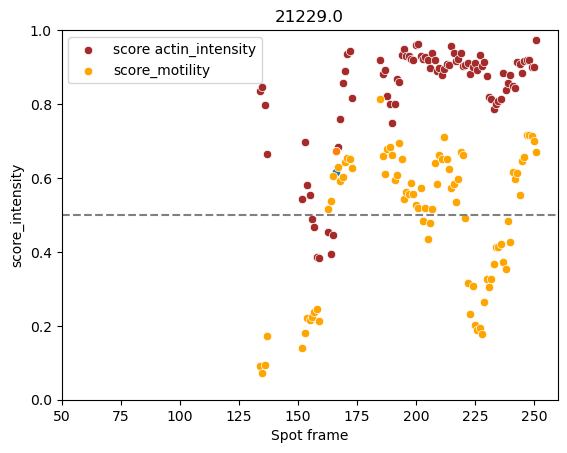

7126.0


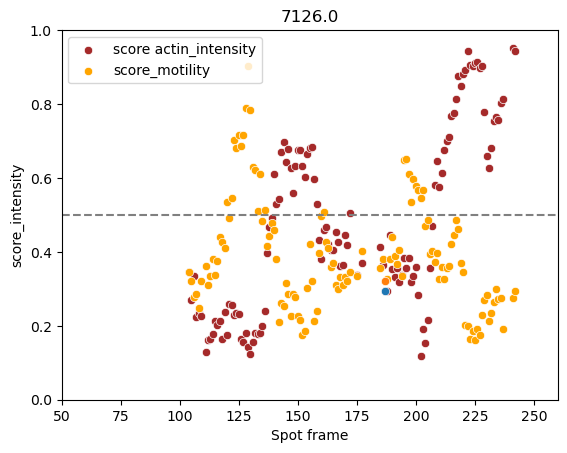

6398.0


IndexError: list index out of range

In [25]:
# plot single cell differentiation trajectory with fusion time

def plot_single_cell_fusion_time(nth_cell):
    track_id = list(fusions_properties["Spot track ID"].unique())[nth_cell]
    print(track_id)
    track_data = fusions_properties[(fusions_properties["Spot track ID"]==track_id)]
    if len(track_data)>1:
        sns.scatterplot(x=track_data["Spot frame"], y="score_intensity", data=track_data, label="score actin_intensity", color="brown")
        sns.scatterplot(x=track_data["fusion_frame"], y="score_intensity", data=track_data[(track_data["time"]==track_data["fusion_time"])])

        sns.scatterplot(x=track_data["Spot frame"], y="score_motility", data=track_data, label="score_motility", color="orange")
        sns.scatterplot(x=track_data["fusion_frame"], y="score_motility", data=track_data[(track_data["time"]==track_data["fusion_time"])])

        plt.axhline(0.5, color='gray', linestyle='dashed')
        plt.title(track_id)
        plt.ylim((0,1))
        plt.xlim((50,260))
        plt.show()

for i in range(760):
    plot_single_cell_fusion_time(i)

## summary

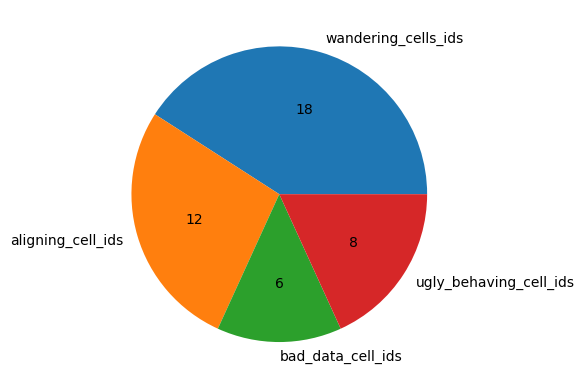

In [26]:
# summary - fusion time tagged cells:

wandering_cell_ids = [218, 1395, 4969, 6997, 7473, 10500, 11126, 12549, 14341, 14944, 16377, 16802, 17020, 17229, 19022, 21560, 23937, 28965, ]
aligning_cell_ids = [2768, 3664, 8610, 8674, 9254, 8610, 8674, 9254, 16034, 19263, 27915, 28879, ]
bad_data_cell_ids = [7651, 14854, 16073, 19911, 2723, 29411, ]
ugly_behaving_cell_ids = [7131, 7344, 7800, 9419, 11199, 12623, 13409, 21237,]

lengths = {"wandering_cells_ids":len(wandering_cell_ids), 
          "aligning_cell_ids":len(aligning_cell_ids), 
          "bad_data_cell_ids":len(bad_data_cell_ids), 
          "ugly_behaving_cell_ids":len(ugly_behaving_cell_ids)}

plt.pie(lengths.values(), 
        labels=lengths.keys(),
       autopct=lambda x:int(round(x/100.*sum(list(lengths.values())))))
plt.show()


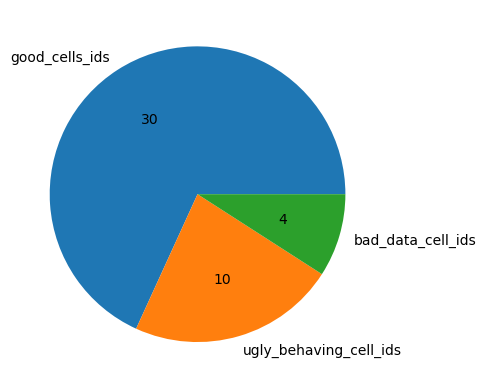

In [7]:
good = [217, 19015, 16792, 9245, 1394, 17012, 16025, 14936, 3661, 19256, 16368, 10887, 16111, 17043, 2766, 6992, 11115, 27908, 12208, 28872,  4964, 8665, 13402, 28958, 21552, 7465, 17223, 8601, 23928, 14334, ]
ugly = [9410, 12539, 11188, 12613, 7791, 3642, 10490, 7338, 21229, 7126]
bad_track = [27245, 14847, 16064, 19904]

lengths = {"good_cells_ids":len(good), 
          "ugly_behaving_cell_ids":len(ugly), 
          "bad_data_cell_ids":len(bad_track),}

plt.pie(lengths.values(), 
        labels=lengths.keys(),
       autopct=lambda x:int(round(x/100.*sum(list(lengths.values())))))
plt.show()

In [8]:
# define differentiation threshold
DIFF_SCORE_THRESHOLD = 0.7

In [9]:
# check min differentiation frame (motility)
df = fusions_properties[(fusions_properties["score_motility"]>=DIFF_SCORE_THRESHOLD) & (fusions_properties["time"]>=6)].groupby("Spot track ID")["Spot frame", "fusion_frame"].agg({'min'})
df.columns = df.columns.droplevel(1)
df["Spot frame"].mean()

136.8409090909091

In [14]:
def get_terminal_differentiation_time(diff_threshold, track_df, modality):
    high_then_thresh = track_df[(track_df[f"score_{modality}"] >= diff_threshold) & (track_df[f"time"] >= 6 )]
    diff_frame = round(high_then_thresh["Spot frame"].min(),3)
    diff_time = round(high_then_thresh["time"].min(),3)     
    return diff_frame, diff_time

print(get_terminal_differentiation_time(DIFF_SCORE_THRESHOLD, fusions_properties[fusions_properties["Spot track ID"]==9410.0], "motility"))
print(get_terminal_differentiation_time(DIFF_SCORE_THRESHOLD, fusions_properties[fusions_properties["Spot track ID"]==217.0], "motility"))

(87.0, 7.25)
(76.0, 6.333)


## calculate some fusion parameters

such as: 
* time/distance between track's start and fusion time
* time/distance between track's terminal-differentiation time (according to the threshold) and fusion time.

In [13]:
def get_distance_to_fusion(track_df, diff_frame=None):
    """
    computes the displacement of single cell until fusion time. 
    if diff_frame=None, computes the displacement from the first time-point of the track
    else, computes the displacement from the time-point wehre the cell reached to terminal differentiation state.
    """
    start_frame = 0 if diff_frame is None else diff_frame
    track_df_cropped = track_df[track_df["Spot frame"] >= start_frame]
    if track_df_cropped.empty:
        print(track_df, start_frame)

    track_df_cropped = track_df_cropped.sort_values("Spot frame")
    displacement = get_displacement(track_df_cropped["Spot position X"], track_df_cropped["Spot position Y"])
    return displacement

def get_correlation_with_time(track_df, modality, time, rolling_window=6):
    track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    corr = np.array(track_df.astype('float64').groupby('Spot track ID').apply(lambda df: df[f"score_{modality}"].rolling(rolling_window).mean().corr(df["time"].rolling(rolling_window).mean(),method="pearson")))
    corr = corr[0] if len(corr) > 0 else np.nan 
    return round(corr, 3)

print(get_correlation_with_time(fusions_properties[fusions_properties["Spot track ID"]==217], "motility", time=(6,10.8)))

0.656


In [11]:
def calc_single_cell_fusion_properties(track_df, modality):
    diff_frame, diff_time = get_terminal_differentiation_time(DIFF_SCORE_THRESHOLD, track_df, modality)
    if np.isnan(diff_frame):
        return
    dist_to_fusion_start = get_distance_to_fusion(track_df, diff_frame=None)
    dist_to_fusion_diff = get_distance_to_fusion(track_df, diff_frame=diff_frame)
    n_frames_diff_fusion = abs(track_df["fusion_frame"].iloc[0] - diff_frame)
    time_diff_fusion = n_frames_diff_fusion * 5 / 60
    corr_with_time = get_correlation_with_time(track_df, modality, time=(0, diff_time))
    
    properties = {"Spot track ID": track_df["Spot track ID"].iloc[0], 
                  "fusion_time": track_df["fusion_time"].iloc[0],
                  "diff_time": diff_time, 
                  "dist_from_start_to_fusion": dist_to_fusion_start, 
                  "dist_from_diff_to_fusion": dist_to_fusion_diff, 
                  "time_from_diff_to_fusion": time_diff_fusion,
                 "correlation_with_time": corr_with_time}
    return properties

def calc_fusion_properties(df, modality):
    df_fusion_props = pd.DataFrame()
    for track_id, track_df in df.groupby("Spot track ID"):
        if len(track_df) > 1:
            fusion_properties = calc_single_cell_fusion_properties(track_df, modality)
            if fusion_properties:
                df_fusion_props = df_fusion_props.append(fusion_properties, ignore_index=True)
    return df_fusion_props

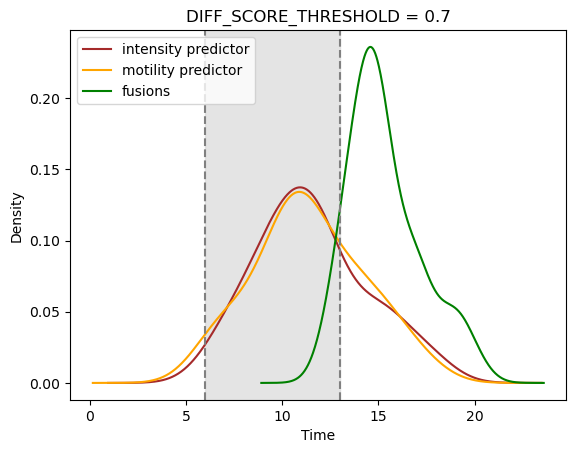

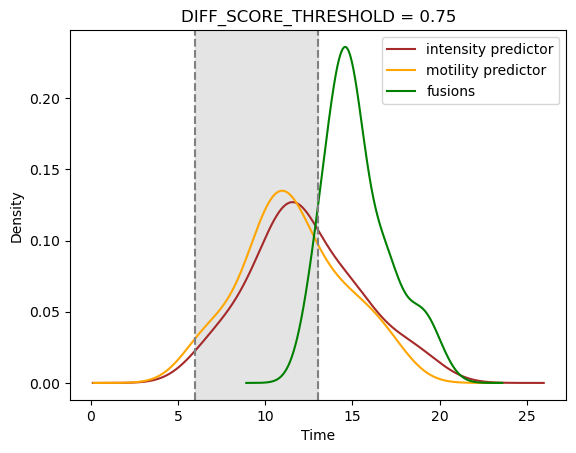

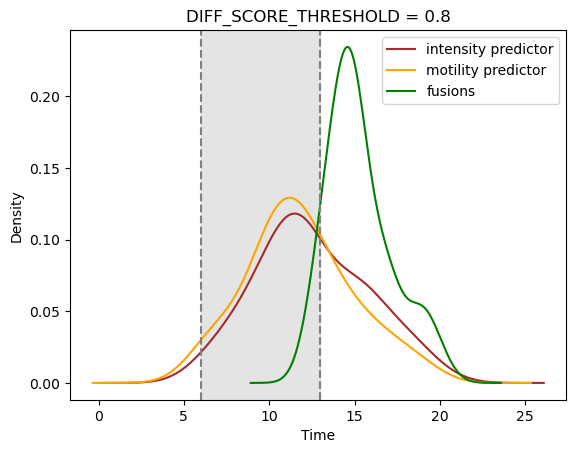

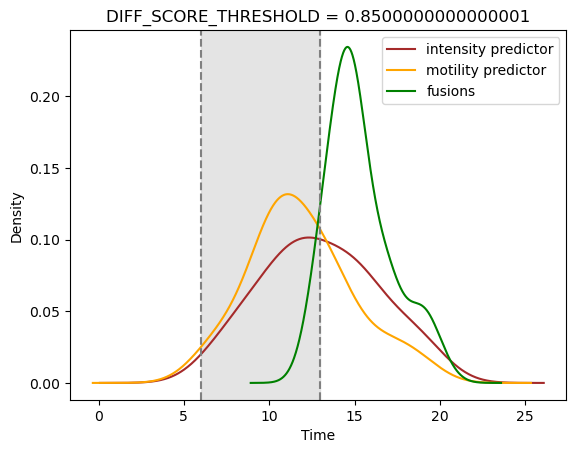

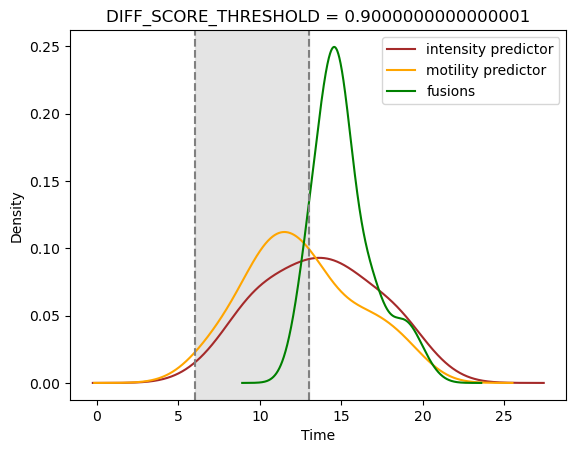

In [20]:
for i in np.arange(0.7, 0.95, 0.05):
    DIFF_SCORE_THRESHOLD = i
    df_fusion_props_mot_i = calc_fusion_properties(fusions_properties, "motility")  
    df_fusion_props_int_i = calc_fusion_properties(fusions_properties, "intensity") 

    df_fusion_props_int_i["diff_time"].plot.density(color="brown", label="intensity predictor")
    df_fusion_props_mot_i["diff_time"].plot.density(color="orange", label="motility predictor")
    
    
    df_fusion_props_int_i["fusion_time"].plot.density(color="green", label="fusions")

    plt.axvspan(6, 13, alpha=0.6, color='lightgray')
    plt.axvline(6, color='gray', linestyle='dashed')
    plt.axvline(13, color='gray', linestyle='dashed')
    plt.title(f"DIFF_SCORE_THRESHOLD = {i}")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

## correlate parameters

In [ ]:
DIFF_SCORE_THRESHOLD = 0.7

df_fusion_props_mot = calc_fusion_properties(fusions_properties, "motility")  
df_fusion_props_int = calc_fusion_properties(fusions_properties, "intensity")  

# sns.heatmap(df_fusion_props_mot.drop(columns="Spot track ID").corr(), cmap="YlGnBu", annot=True)

0.43662813833389813 0.43952309948819523


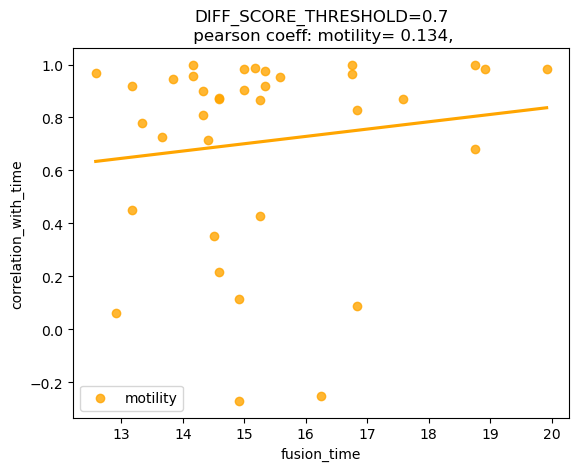

0.7381763997678215 0.34775153091562505


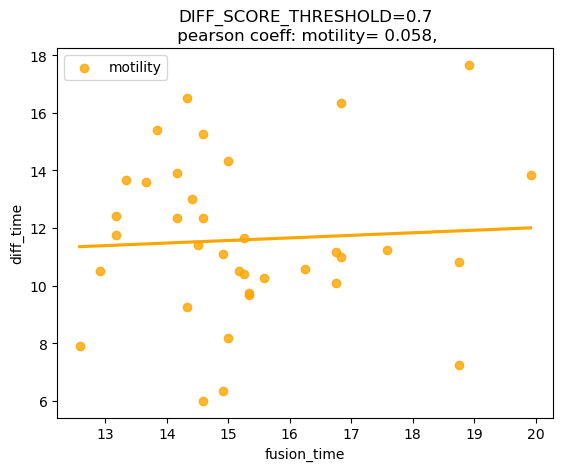

0.058103619888215864 0.058103619888215864


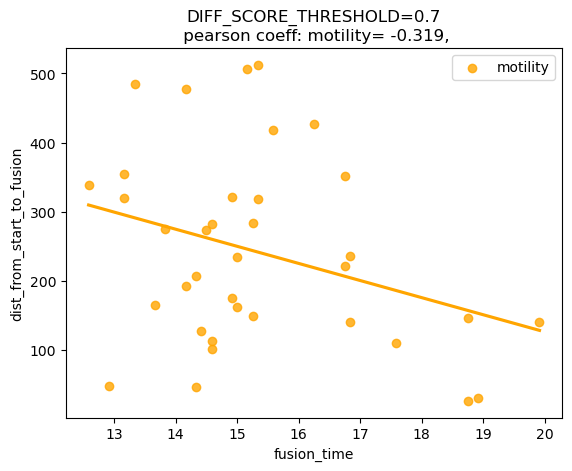

0.5495103040889819 0.5242145772515061


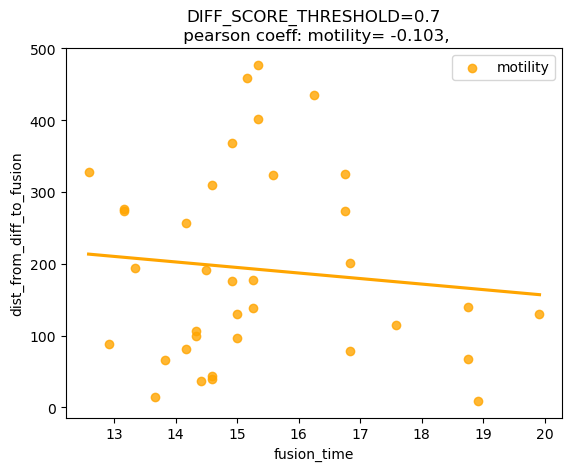

0.0016050473902073344 0.017250695587719127


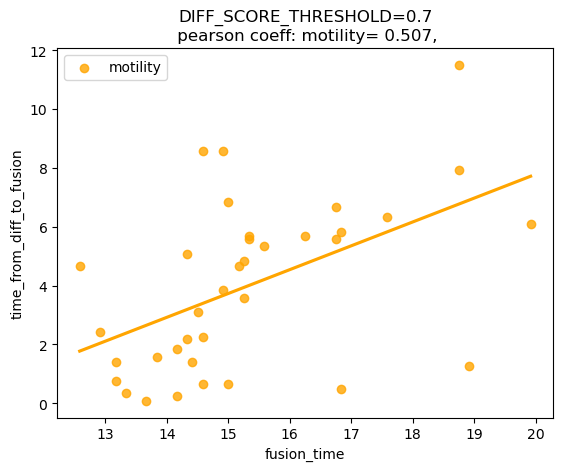

0.0009760015239859791 0.15210729524946864


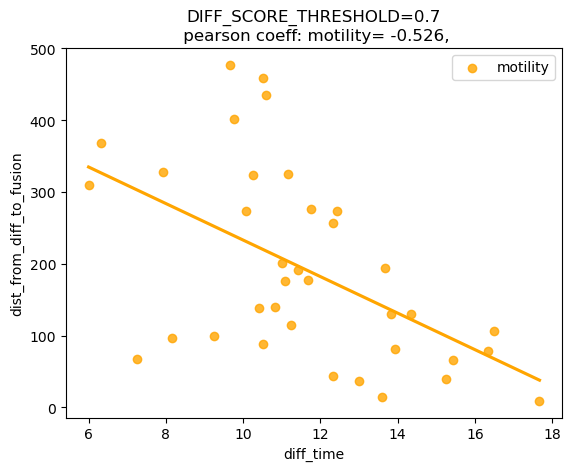

1.2270075961211247e-08 4.130017769777168e-06


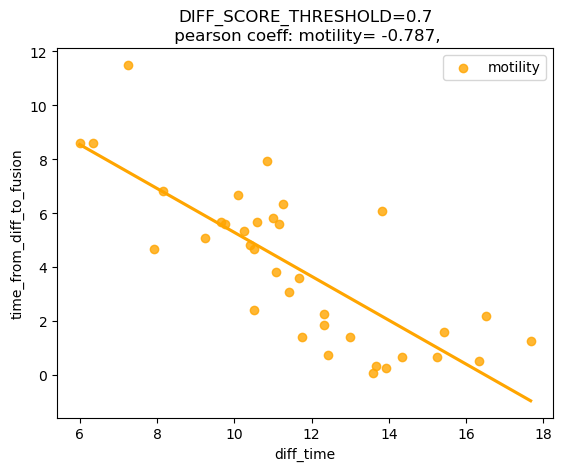

0.7381763997678215 0.34775153091562505


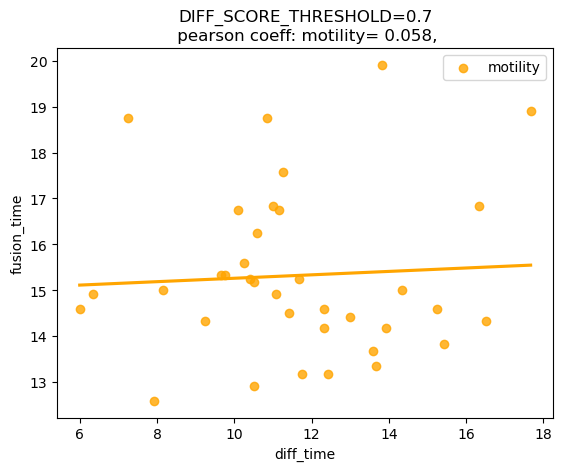

In [23]:
def plot_corr(x_col, y_col, mot_data, int_data, title):
    mot_data = mot_data.dropna()
    int_data = int_data.dropna()
    sns.regplot(x=x_col, y=y_col, data=mot_data, color="orange", ci=None, label="motility")
#     sns.regplot(x=x_col, y=y_col, data=int_data, color="brown", ci=None, label="intensity")
    
    p_mot, p_val_mot = scipy.stats.pearsonr(mot_data[x_col], mot_data[y_col])
    p_int, p_val_int = scipy.stats.pearsonr(int_data[x_col], int_data[y_col])
    print(p_val_mot, p_val_int)
    plt.title(title + f"\n pearson coeff: motility= {round(p_mot,3)},") #, intensity= {round(p_int,3)}
    plt.legend()
    plt.show()

title = f"DIFF_SCORE_THRESHOLD={DIFF_SCORE_THRESHOLD}"

mot_data = df_fusion_props_mot[df_fusion_props_mot["Spot track ID"].isin(good + ugly)] #wandering
int_data = df_fusion_props_int[df_fusion_props_int["Spot track ID"].isin(good + ugly)] #aligning

plot_corr("fusion_time", "correlation_with_time", mot_data, int_data, title)
plot_corr("fusion_time", "diff_time", mot_data, int_data, title)
plot_corr("fusion_time", "dist_from_start_to_fusion", mot_data, mot_data, title)
plot_corr("fusion_time", "dist_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("fusion_time", "time_from_diff_to_fusion", mot_data, int_data, title)

plot_corr("diff_time", "dist_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("diff_time", "time_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("diff_time", "fusion_time", mot_data, int_data, title)


In [ ]:
df_fusion_props_int_i["diff_time"].plot.density(color="brown", label="intensity")
df_fusion_props_mot_i["diff_time"].plot.density(color="orange", label="motility")

df_fusion_props_int_i["fusion_time"].plot.density(color="green", label="intensity")